In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from qnorm import quantile_normalize
from wmb import cemba
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
from scipy import stats
from ALLCools.mcds.correlation import corr_rows
from tqdm import tqdm
import glob
import joblib

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

In [2]:
import joblib
mt_pelatte = joblib.load('/home/qzeng/project/aging/231117_update_annot/AgingMajorType_Palette')

new_mt_palette = {}
for mt ,_color in mt_pelatte.items():
    mt= mt.replace('/','').replace(' ','_')
    new_mt_palette[mt] = _color

In [3]:
dmr_dir = '/home/qzeng/project/aging/230907-recall-dmr/Merge_DMR/mC_FILTER_DMR_BED'
male_atac_dir = '1000_atac_counts'
_type = 'Hypo'

In [4]:
meta = pd.read_csv('/home/qzeng/project/aging/metadata/240104_mC_META.csv', index_col =0)
meta['AgingMajorType'] = meta['AgingMajorType'].apply(lambda x: x.replace('/','').replace(' ','_'))

/home/qz/miniconda3/envs/allcools/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
major_cts = joblib.load('/home/qzeng/project/aging/metadata/shared_use_cts')
major_cts = [ct.replace('/','').replace(' ','_') for ct in major_cts]

In [6]:
has_cts = [path.split('/')[-1].split('.')[0] for path in glob.glob(f'{male_atac_dir}/*.{_type}.*')]

In [7]:
use_cts = list(set(major_cts) & set(has_cts))
len(use_cts)

26

In [8]:
# all_corr = []
# dmr_number = []
# for ct in tqdm(use_cts):
#     dmr_df = pd.read_csv(f'{dmr_dir}/{ct}.{_type}.aDMR.bed', sep = '\t', 
#                       header = None, index_col =3)
#     sorted_dmr_order = sorted(dmr_df.index)
#     mc_data = dmr_df[[4,5,6]]
    
#     atac_data = pd.read_csv(f'1000_atac_counts/{ct}.{_type}.csv', index_col = 0)
    
#     mc_data = mc_data.div(mc_data.sum(axis = 1), axis = 0).loc[sorted_dmr_order].round(2)
#     atac_data = atac_data.div(atac_data.sum(axis = 1), axis = 0).fillna(0).loc[sorted_dmr_order].round(2)
    
#     corr = corr_rows(mc_data, atac_data)
#     corr =pd.DataFrame({'corr':corr})
#     corr.index = sorted_dmr_order
#     corr['length'] = [int(dmr_id.split('-')[2]) - int(dmr_id.split('-')[1]) for dmr_id in corr.index]
#     corr = corr[corr['length'] >= 250]
    
#     pcorr = round(corr['corr'].dropna().mean(),2)
#     all_corr.append(pcorr)
#     dmr_number.append(len(sorted_dmr_order))
#     #corr.to_csv(f'pcc_results/{ct}.csv')
    

In [45]:
all_corr = []
dmr_number = []
for ct in tqdm(use_cts):
    dmr_df = pd.read_csv(f'{dmr_dir}/{ct}.{_type}.aDMR.bed', sep = '\t', 
                      header = None, index_col =3)
    sorted_dmr_order = sorted(dmr_df.index)
    mc_data = dmr_df[[4,5,6]]
    
    atac_data = pd.read_csv(f'{male_atac_dir}/{ct}.{_type}.csv', index_col = 0)
    
    mc_data = mc_data.div(mc_data.sum(axis = 1), axis = 0).loc[sorted_dmr_order].round(2)
    atac_data = atac_data.div(atac_data.sum(axis = 1), axis = 0).fillna(0).loc[sorted_dmr_order].round(2)
    
    corr = corr_rows(mc_data, atac_data)
    corr =pd.DataFrame({'corr':corr})
    corr.index = sorted_dmr_order
    corr['length'] = [int(dmr_id.split('-')[2]) - int(dmr_id.split('-')[1]) for dmr_id in corr.index]
    if _type == 'Hypo':
        corr = corr[corr['length'] >= 250]
    if _type == 'Hyper':
        corr = corr[corr['length'] >= 2]
    pcorr = round(corr['corr'].dropna().mean(),2)
    
    all_corr.append(pcorr)
    dmr_number.append(len(sorted_dmr_order))
    #corr.to_csv(f'pcc_results/{ct}.csv')
    

100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


In [46]:
all_corr = pd.DataFrame({'corr':all_corr, 'mc_num':dmr_number}, index = use_cts)
all_corr['celltype'] = all_corr.index
all_corr = all_corr.sort_values('corr')
all_corr.sort_values('corr').head()

,corr,mc_num,celltype
DG_Glut,-0.86,6989,DG_Glut


In [20]:
mean_corr = all_corr['corr'].mean()
mean_corr

-0.29076923076923084

In [21]:
# order by class
glut_cts = []
gaba_cts = []
nn_cts = []
for ct in all_corr.index:
    if ct.endswith('Glut'):glut_cts.append(ct)
    elif ct.endswith('Gaba'):gaba_cts.append(ct)
    elif ct.endswith('NN'):nn_cts.append(ct)

new_order = glut_cts + gaba_cts + nn_cts
all_corr = all_corr.loc[new_order]

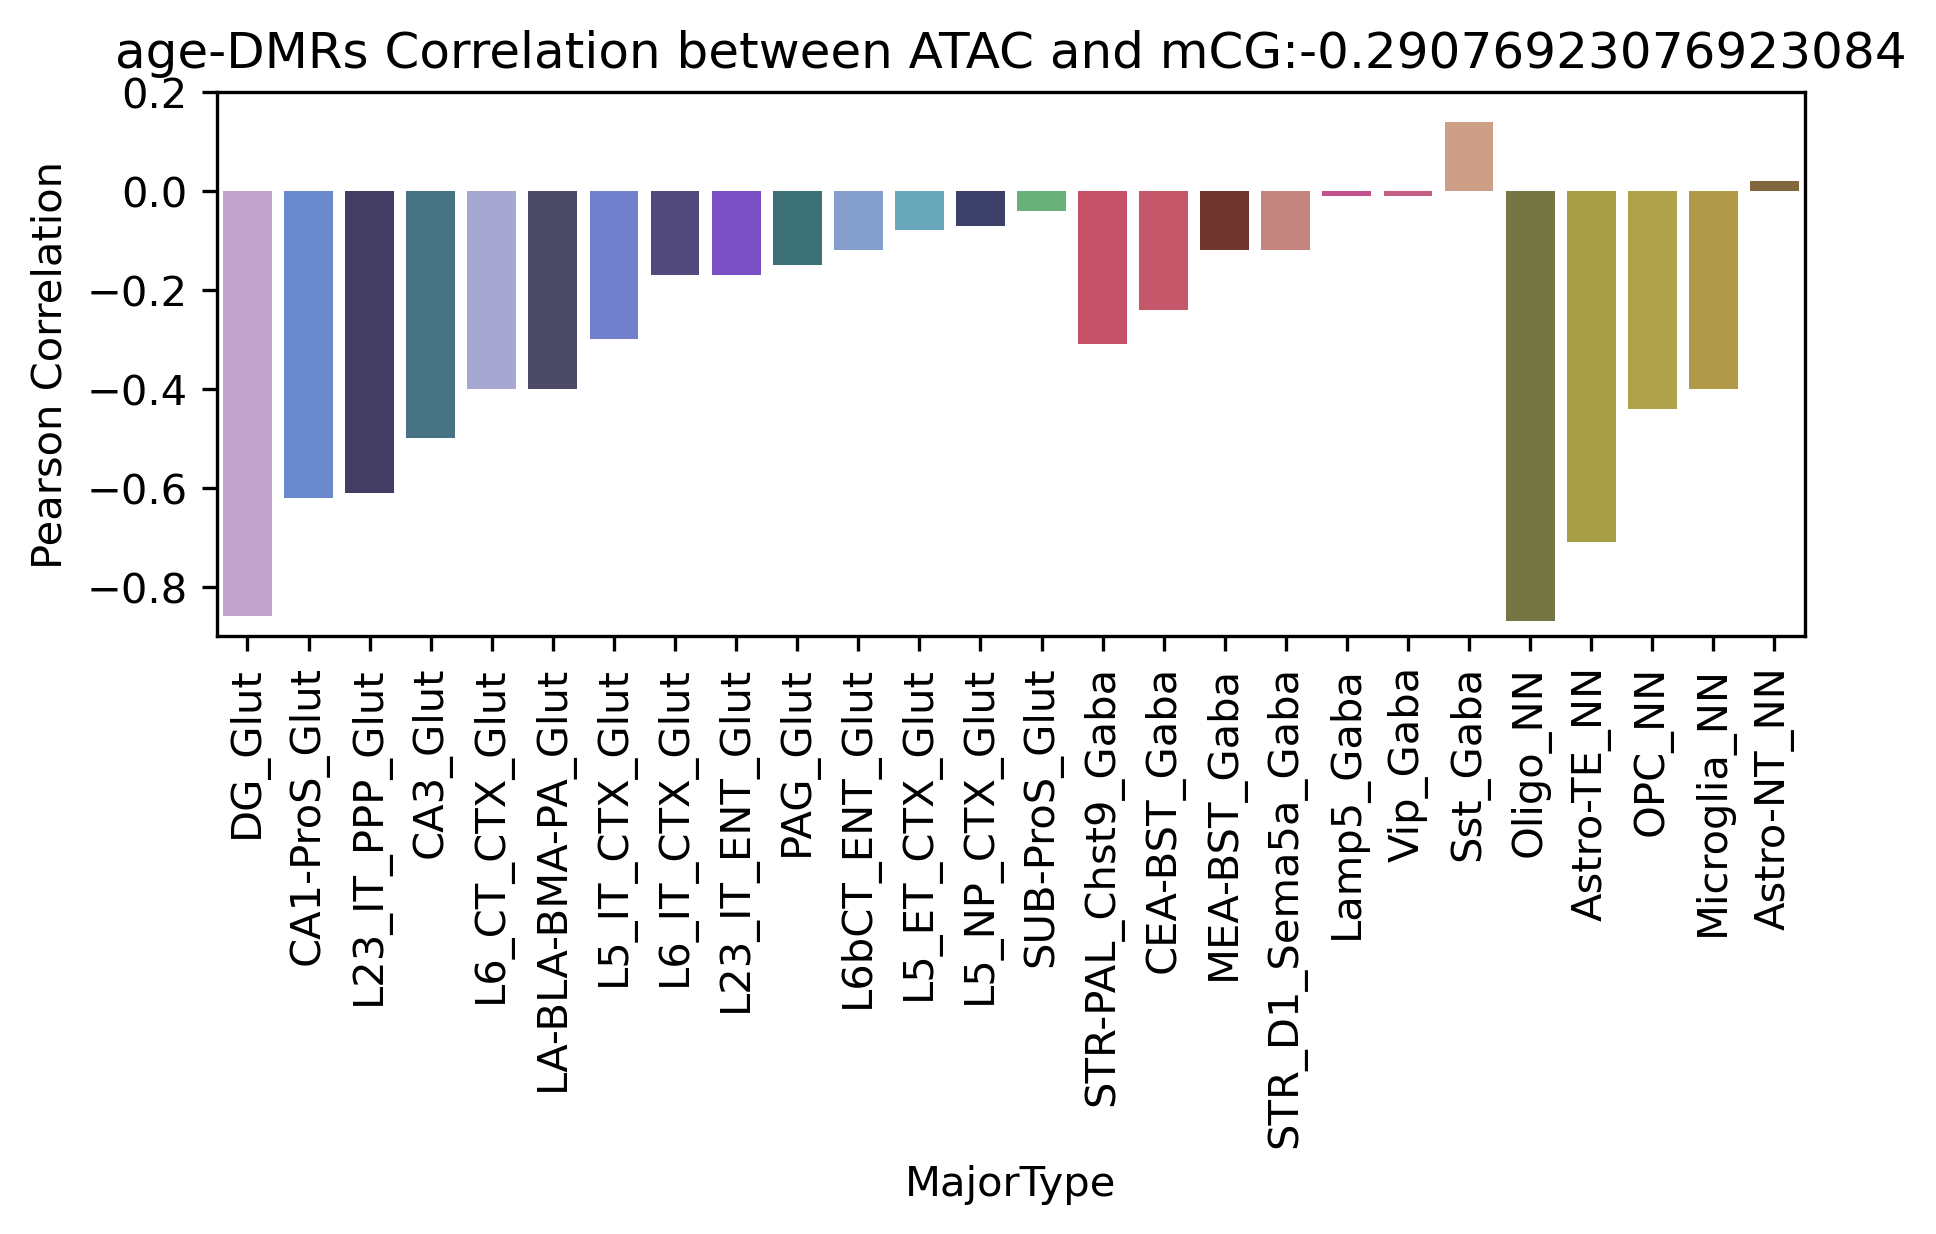

In [23]:
fig, ax =plt.subplots(figsize = (6,4), dpi = 300, constrained_layout = True)
sns.barplot(data = all_corr, 
            x="celltype", 
            y="corr", 
            hue="celltype", 
            palette = new_mt_palette,
            ax = ax,
            dodge=False,
            )

ax.legend_.remove()
#plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f'age-DMRs Correlation between ATAC and mCG:{mean_corr}')
plt.xlabel('MajorType')
plt.ylabel('Pearson Correlation')
plt.xticks(rotation=90)
ax.set_ylim(-0.9, 0.2)
fig.savefig(f'{_type}.aDMR.ATAC_mC.Corr.pdf', bbox_inches = 'tight')
plt.show()

In [46]:
# mc_data['mc_change'] = mc_data[6] - mc_data[4]
# atac_data['atac_change'] = atac_data['18mo'] - atac_data['2mo']

In [47]:
# toplot = pd.concat([mc_data['mc_change'],atac_data['atac_change']], axis = 1)

In [48]:
# res = stats.pearsonr(toplot['mc_change'], toplot['atac_change'])
# res

In [49]:
# fig, ax = plt.subplots(figsize = (3,3),  dpi = 200, constrained_layout = True)
# sns.scatterplot(data = toplot,
#                 rasterized = True,
#                 s = 3,linewidth = 0,
#                x = 'mc_change',
#                y = 'atac_change')

In [18]:
# cell_counts = meta['AgingMajorType'].value_counts()
# major_cts = cell_counts[cell_counts > 1500].index

In [19]:
# confusion_matrix = pd.read_hdf('/home/qzeng/project/aging/231127-plot-integration-all/ATAC-celltype_final.mC-AgingMajorType.overlap_score.hdf', 
#                                key = 'data')

In [20]:
# use_cts = [ct.replace('/','').replace(' ','_') for ct in confusion_matrix.columns] + ['Oligo_NN','Astro-NT_NN','Astro-TE_NN','OPC_NN','Microglia_NN','VLMC_NN','Endo_NN']

In [21]:
# fig, axes = plt.subplots(figsize=(7, 3), ncols=2, dpi=200)
# ax = axes[0]
# vmin, vmax = np.quantile(mc_data, [0.1, 0.9])
# ax.imshow(mc_data, aspect="auto", vmin=vmin, vmax=vmax)
# ax.set_title(f"mCG Frac {vmin:.2f} {vmax:.2f}")
# tick_positions = np.arange(mc_data.shape[1])  # Assuming mc_data has three columns
# ax.set_xticks(tick_positions)
# ax.set_xticklabels(['2mo', '9mo', '18mo'])

# ax = axes[1]
# vmin, vmax = np.quantile(atac_data, [0.1, 0.9])
# ax.imshow(atac_data, aspect="auto", vmin=vmin, vmax=vmax)
# ax.set_title(f"ATAC {vmin:.2f} {vmax:.2f}")
# tick_positions = np.arange(mc_data.shape[1])  # Assuming mc_data has three columns
# ax.set_xticks(tick_positions)
# ax.set_xticklabels(['2mo', '9mo', '18mo'])

In [22]:
# fig, ax = plt.subplots(figsize=(4, 3), dpi=100)
# sns.histplot(ax=ax, data=corr, kde = True, color='red', bins=100, binrange=(-1, 1))
# #sns.histplot(ax=ax, data=shuffle_corr,kde = True, color='lightgrey', bins=100, binrange=(-1, 1))

In [23]:
# shuffle_mc_data = pd.DataFrame(
#     [col.sample(mc_data.shape[0]).values for _, col in mc_data.items()]
# ).T

In [24]:
# shuffle_atac_data = pd.DataFrame(
#     [col.sample(atac_data.shape[0]).values for _, col in atac_data.items()]
# ).T

In [25]:
# shuffle_corr = corr_rows(shuffle_mc_data, shuffle_atac_data)
# pd.Series(shuffle_corr).dropna().mean()

In [26]:
# total_counts = pd.read_csv(f'{male_atac_dir}/{ct}.Male.{_type}.aDMR.counts.txt.summary', sep = '\t', index_col = 0,skiprows=0)
# total_counts = total_counts.sum()
# total_counts.head()

# use_sample = total_counts[total_counts > 100000].index
# use_sample[:5]

# atac_df = pd.read_csv(f'{male_atac_dir}/{ct}.Male.{_type}.aDMR.counts.txt', sep = '\t', skiprows=1, index_col = 'Geneid').T
# atac_df = atac_df.loc[~atac_df.index.isin(['Chr','Start','End','Strand','Length'])] * 1000000
# atac_df = atac_df.loc[use_sample]

# norm_atac_df = atac_df.div(total_counts.loc[], axis = 0)
# norm_atac_df['age'] = norm_atac_df.index.map(lambda x: x.split(':')[1].split('_')[0])

# atac_data = norm_atac_df.groupby('age').mean().T
# #atac_data = atac_data[['2mo','9mo','18mo']].loc[sorted_dmr_order]
# atac_data.head()